# Practical Two: Species Distribution Modelling

## Required packages


There are many R packages available for species distribution modelling. If you search through the [CRAN package index](https://cran.r-project.org/web/packages/index.html) for 'species distribution', you will find over 20 different packages that do something - and that is only using a single search term. 

We are going to concentrate on the `dismo` package: it is a little old but provides a single framework to handle different model types. It also has an excellent **vignette** (a detailed tutorial on how to use the package) for further details:

https://cran.r-project.org/web/packages/dismo/vignettes/sdm.pdf

The following packages are required: these will be pre-installed in the RStudio Cloud project, but you will need to load them if you are working on your own machine

```r <!-- This is nicely styled but not executed by Jupyter. Basically, show don't run.-->
install.packages('raster') # Core raster GIS data package
install.packages('sf') # Core vector GIS data package
install.packages('sp') # Another core vector GIS package
install.packages('dismo') # Species Distribution Modelling
install.packages('rgdal') # Interface to the Geospatial Data Abstraction Library
```

To load the packages:

In [1]:
library(rgdal)
library(raster)
library(sf)
library(sp)
library(dismo)

Loading required package: sp



rgdal: version: 1.5-18, (SVN revision 1082)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 2.4.2, released 2019/06/28
Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/3.6/Resources/library/rgdal/gdal
GDAL binary built with GEOS: FALSE 
Loaded PROJ runtime: Rel. 5.2.0, September 15th, 2018, [PJ_VERSION: 520]
Path to PROJ shared files: /Library/Frameworks/R.framework/Versions/3.6/Resources/library/rgdal/proj
Linking to sp version:1.4-4
Overwritten PROJ_LIB was /Library/Frameworks/R.framework/Versions/3.6/Resources/library/rgdal/proj



Linking to GEOS 3.7.2, GDAL 2.4.2, PROJ 5.2.0



<!-- ### Installing MaxEnt

We are going to be using the MAXENT species distribution modelling program. Using MaxEnt in R is a bit of a pain, because it requires the MAXENT program to be separately installed and also requires the `rJava` package. The RStudio Cloud project for this practical is all ready to go, but if you want to follow this on your own machine then you will need to:

1. Download the MAXENT program - this is a compiled Java program file `maxent.jar`:

[https://github.com/mrmaxent/Maxent/blob/master/ArchivedReleases/3.3.3k/maxent.jar?raw=true](https://github.com/mrmaxent/Maxent/blob/master/ArchivedReleases/3.3.3k/maxent.jar?raw=true)

2. Save that into the `dismo/java` folder in your R library.

MaxEnt is a very widely used program that uses a Maximum Entropy approach to fit species models. We are *not* going to be getting into the details of the way the algorithm works, but you can read up on that here:

> Elith, J., Phillips, S.J., Hastie, T., Dudík, M., Chee, Y.E. and Yates, C.J. (2011), A statistical explanation of MaxEnt for ecologists. Diversity and Distributions, 17: 43-57. [doi:10.1111/j.1472-4642.2010.00725.x](https://doi.org/10.1111/j.1472-4642.2010.00725.x)

It [has been pointed out](https://methodsblog.com/2013/02/20/some-big-news-about-maxent/) that MaxEnt is actually equivalent to a Generalised Linear Model (GLM), but we will use a few approaches here and MaxEnt is a framework that has been widely used and discussed.

-->


## Introduction

This practical gives a basic introduction to species distribution modelling using R. We will be using R to characterise a selected species environmental requirements under present day climatic conditions and then projecting the availability of suitable climatic conditions into the future. This information will then be used to analyse projected range changes due to climate change. During this process we will analyse the performance of species distribution models and the impacts of threshold choice, variable selection and data availability on model quality.

## Data preparation

There are two main inputs to a species distribution model. The first is a set of points describing locations in which the species is known to be found. The second is a set of environmental raster layers – these are the variables that will be used to characterise the species’ environmental niche by looking at the environmental values where the species is found. 

### Focal species distribution

We will be using the Mountain Tapir (_Tapirus pinchaque_) as an example species.

![_Tapirus pinchaque_. © Diego Lizcano](images/tapirus-pinchaque.jpg)
_Tapirus pinchaque_. © Diego Lizcano

I have picked this because it has a fairly narrow distribution but also because there is reasonable data in two distribution data sources:

* The IUCN Red List database: [Mountain Tapir](https://www.iucnredlist.org/species/21473/45173922), which is a good source of polygon species ranges. These ranges are usually _expert drawn maps_: interpretations of sighting data and local information.

* The GBIF database: [Mountain Tapir](https://www.gbif.org/species/2440899), which is a source of point observations of species. It is hugely important to be critical of point observation data and carefully clean it. There is a great description of this process in the `dismo` vignette on species distribution modelling:

```r
vignette('sdm')
```

We can view both kinds of data for this species. 

* The IUCN data is a single MULTIPOLYGON feature showing the discontinuous sections of the species' range. There are a number of feature attributes, described in detail in [this pdf](https://nc.iucnredlist.org/redlist/resources/files/1539098236-Mapping_Standards_Version_1.16_2018.pdf).

In [2]:
tapir_IUCN <- st_read('data/iucn_mountain_tapir/data_0.shp')
print(tapir_IUCN)

Reading layer `data_0' from data source `/Users/dorme/Teaching/GIS/Masters_GIS_2020/practicals/practical_2/data/iucn_mountain_tapir/data_0.shp' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 15 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -79.62289 ymin: -5.962554 xmax: -73.82314 ymax: 5.031971
CRS:            4326


Simple feature collection with 1 feature and 15 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -79.62289 ymin: -5.962554 xmax: -73.82314 ymax: 5.031971
CRS:            4326
  ASSESSMENT ID_NO          BINOMIAL PRESENCE ORIGIN SEASONAL COMPILER YEAR
1   45173922 21473 Tapirus pinchaque        1      1        1     IUCN 2008
                                               CITATION            LEGEND
1 IUCN (International Union for Conservation of Nature) Extant (resident)
  SUBSPECIES SUBPOP DIST_COMM ISLAND TAX_COMM                       geometry
1       <NA>   <NA>      <NA>   <NA>     <NA> MULTIPOLYGON (((-78.00009 0...


* The GBIF data is a table of observations, some of which include coordinates. One thing that GBIF does is to publish a DOI for every download, to make it easy to track particular data use. This one is [https://doi.org/10.15468/dl.t2bkzx](https://doi.org/10.15468/dl.t2bkzx).

There are some tricks to loading the GBIF data. Although GBIF use the file `.csv` suffix, the file is in fact _tab_ delimited so we need to use `read.delim()`. There is a lot of text data in the file, so the option `stringsAsFactors=FALSE` to turn off R's daft default behaviour of turning all text fields into categorical variables is really useful. Lastly, we need to remove rows with no coordinates.

In [3]:
# Load the data frame
tapir_GBIF <- read.delim('data/gbif_mountain_tapir.csv', 
                         stringsAsFactors=FALSE)
# Drop rows with missing coordinates
tapir_GBIF <- subset(tapir_GBIF, ! is.na(decimalLatitude) | ! is.na(decimalLongitude))
# Convert to an sf object 
tapir_GBIF <- st_as_sf(tapir_GBIF, coords=c('decimalLongitude', 'decimalLatitude'))
st_crs(tapir_GBIF) <- 4326
print(tapir_GBIF)

Simple feature collection with 383 features and 48 fields
geometry type:  POINT
dimension:      XY
bbox:           xmin: -78.64301 ymin: -3.101066 xmax: -75.15 ymax: 7.07
CRS:            EPSG:4326
First 10 features:
       gbifID                           datasetKey
1  2868401965 50c9509d-22c7-4a22-a47d-8c48425ef4a7
3  2862366111 50c9509d-22c7-4a22-a47d-8c48425ef4a7
7  2826214836 50c9509d-22c7-4a22-a47d-8c48425ef4a7
8  2826213266 50c9509d-22c7-4a22-a47d-8c48425ef4a7
9  2802920084 50c9509d-22c7-4a22-a47d-8c48425ef4a7
10 2634586094 50c9509d-22c7-4a22-a47d-8c48425ef4a7
11 2634268748 50c9509d-22c7-4a22-a47d-8c48425ef4a7
12 2634229763 50c9509d-22c7-4a22-a47d-8c48425ef4a7
13 2626674279 50c9509d-22c7-4a22-a47d-8c48425ef4a7
14 2626629230 50c9509d-22c7-4a22-a47d-8c48425ef4a7
                                        occurrenceID  kingdom   phylum    class
1  https://www.inaturalist.org/observations/60606393 Animalia Chordata Mammalia
3  https://www.inaturalist.org/observations/58911027 Animalia C

We can now superimpose the two datasets to show they _broadly_ agree. There aren't any obvious problems that require data cleaning.

In [4]:
# Load some (coarse) country background data
ne110 <- st_read('data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

Reading layer `ne_110m_admin_0_countries' from data source `/Users/dorme/Teaching/GIS/Masters_GIS_2020/practicals/practical_2/data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp' using driver `ESRI Shapefile'
Simple feature collection with 177 features and 94 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: -180 ymin: -90 xmax: 180 ymax: 83.64513
CRS:            4326


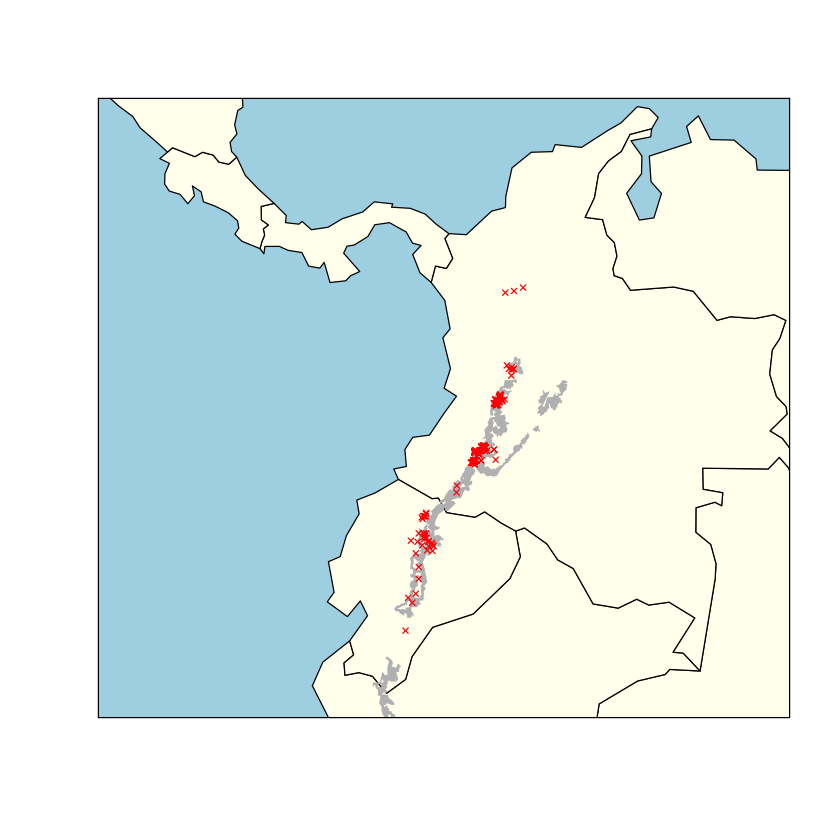

In [5]:
# Create a modelling extent for plotting and cropping the global data.
model_extent <- extent(c(-85,-70,-5,12))

# Plot the species data over a basemap
plot(st_geometry(ne110), xlim=model_extent[1:2], ylim=model_extent[3:4], 
     bg='lightblue', col='ivory')
plot(st_geometry(tapir_IUCN), add=TRUE, col='grey', border=NA)
plot(st_geometry(tapir_GBIF), add=TRUE, col='red', pch=4, cex=0.6)
box()

### Predictor variables

Several sources of different environmental data were mentioned in the lecture, but in this practical we will be using climatic variables to describe the environment. In particular, we will be using the BIOCLIM variables. These are based on simple temperature and precipitation values, but in 19 combinations that are thought to capture more biologically relevant aspects of the climate. These variables are described here:

[https://www.worldclim.org/data/bioclim.html](https://www.worldclim.org/data/bioclim.html)

The data we will us here have been downloaded using the `getData` function from the `raster` package, so should load directly. If you are using your own computer, this code will fetch the data first. The data consist of a stack of the 19 BIOCLIM variables at 10 arc-minute resolution (1/6th degree).

In [6]:
# Load the data
bioclim_hist <- getData('worldclim', var='bio', res=10, path='data')
bioclim_2050 <- getData('CMIP5', var='bio', res=10, rcp=60, model='HD', year=50, path='data')

# Relabel the future variables to match the historical ones
names(bioclim_2050) <- names(bioclim_hist)

# Look at the data structure
print(bioclim_hist)

class      : RasterStack 
dimensions : 900, 2160, 1944000, 19  (nrow, ncol, ncell, nlayers)
resolution : 0.1666667, 0.1666667  (x, y)
extent     : -180, 180, -60, 90  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0 
names      :  bio1,  bio2,  bio3,  bio4,  bio5,  bio6,  bio7,  bio8,  bio9, bio10, bio11, bio12, bio13, bio14, bio15, ... 
min values :  -269,     9,     8,    72,   -59,  -547,    53,  -251,  -450,   -97,  -488,     0,     0,     0,     0, ... 
max values :   314,   211,    95, 22673,   489,   258,   725,   375,   364,   380,   289,  9916,  2088,   652,   261, ... 



The two datasets loaded contain _historical_ climate data (1970-2000) and _projected future_ climate for 2050 taken from the Hadley model using [RCP 6.0](https://en.wikipedia.org/wiki/Representative_Concentration_Pathway). Note that this is CMIP5 data, which is now considered outdated, but is easy to download! Both these datasets are sourced from [http://www.worldclim.org](http://www.worldclim.org).

We can compare `BIO 1` (Mean Annual Temperature) between the two datasets:

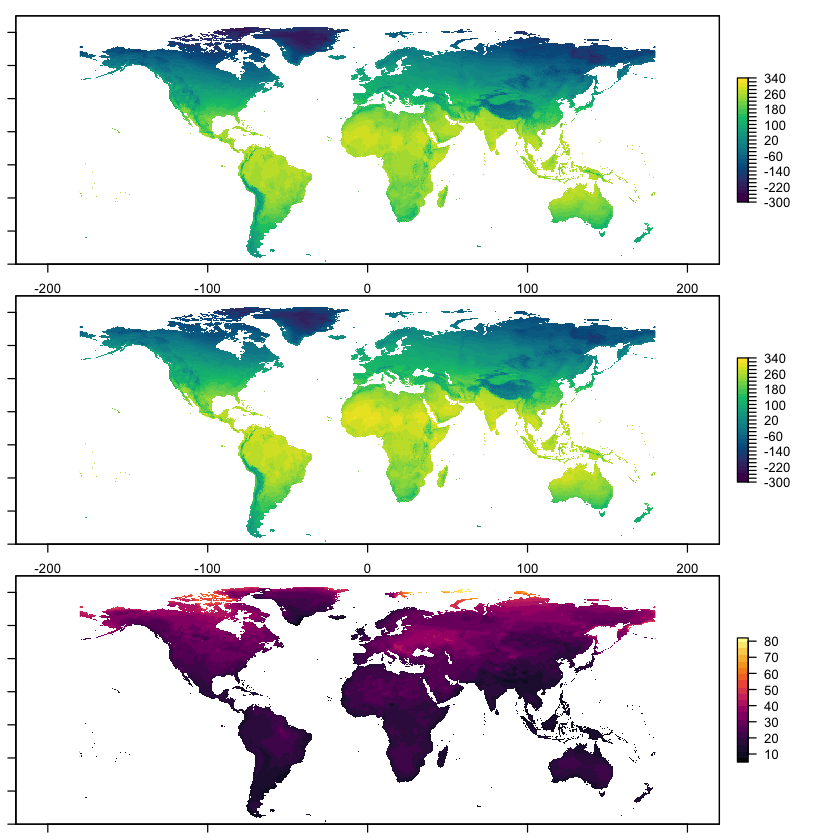

In [7]:
par(mfrow=c(3,1), mar=c(1,1,1,1))
# Create a shared colour scheme
breaks <- seq(-300, 350, by=20)
cols <- hcl.colors(length(breaks) - 1)
# Plot the historical and projected data
plot(bioclim_hist[[1]], breaks=breaks, col=cols)
plot(bioclim_2050[[1]], breaks=breaks, col=cols)
# Plot the temperature difference
plot(bioclim_2050[[1]] - bioclim_hist[[1]], col=hcl.colors(20, palette='Inferno'))

We are immediately going to crop the environmental data down to a sensible modelling region. What counts as _sensible_ here is very hard to define and you may end up changing it when you see model outputs, but here we use a small spatial subset to make things run quickly.

In [8]:
# Reduce the global maps down to the species' range
bioclim_hist_local <- crop(bioclim_hist, model_extent)
bioclim_2050_local <- crop(bioclim_2050, model_extent)

### Pseudo-absence data

Many of the methods below require **absence data**, either for fitting a model or for evaluating the model performance. Rarely, we might actually have real absence data from exhaustive surveys, but usually we only have presence data. So, modelling commonly uses *pseudo-absence* or *background* locations. The difference between those two terms is subtle: I haven't seen a clean definition but *background* data might be sampled completely at random, where *pseudo-absence* makes some attempt to pick locations that are somehow separated from presence observations.

The `dismo` package provides the `randomPoints` function to select background data. It is useful because it works directly with the environmental layers to pick **points representing cells**. This avoids getting duplicate points in the same cells. You do need to provide a **mask layer** that shows which cells are valid choices. You can also exclude cells that contain observed locations by setting `p` to use the coordinates of your observed locations.

In [9]:
# Create a simple land mask
land <- bioclim_hist_local[[1]] >= 0
# How many points to create? We'll use the same as number of observations
n_pseudo <- nrow(tapir_GBIF)
# Sample the points
pseudo_dismo <- randomPoints(mask=land, n=n_pseudo, p=st_coordinates(tapir_GBIF))
# Convert this data into an sf object, for consistency with the
# next example.
pseudo_dismo <- st_as_sf(data.frame(pseudo_dismo), coords=c('x','y'), crs=4326)

We can also use GIS to do something a little more sophisticated. This isn't necessarily the best choice here, but is an example of how to do something more structured. The aim here is to pick points that are within about 100 km of observed points, but not closer than 20km. We are going to cheat and use degrees (1° is very roughly 100 km at the equator), but in practice it would be better to reproject the data and work with real distance units.

In [10]:
# Create buffers around the observed points
nearby <- st_buffer(tapir_GBIF, dist=1)
too_close <- st_buffer(tapir_GBIF, dist=0.2)
# merge those buffers
nearby <- st_union(nearby)
too_close <- st_union(too_close)
# Find the area that is nearby but _not_ too close
nearby <- st_difference(nearby, too_close)
# Get some points within that feature in an sf dataframe
pseudo_nearby <- st_as_sf(st_sample(nearby, n_pseudo))

Warning message in st_buffer.sfc(st_geometry(x), dist, nQuadSegs, endCapStyle = endCapStyle, :
“st_buffer does not correctly buffer longitude/latitude data”


dist is assumed to be in decimal degrees (arc_degrees).



Warning message in st_buffer.sfc(st_geometry(x), dist, nQuadSegs, endCapStyle = endCapStyle, :
“st_buffer does not correctly buffer longitude/latitude data”


dist is assumed to be in decimal degrees (arc_degrees).



although coordinates are longitude/latitude, st_difference assumes that they are planar



although coordinates are longitude/latitude, st_intersects assumes that they are planar



although coordinates are longitude/latitude, st_intersects assumes that they are planar



although coordinates are longitude/latitude, st_intersects assumes that they are planar



although coordinates are longitude/latitude, st_intersects assumes that they are planar



although coordinates are longitude/latitude, st_intersects assumes that they are planar



although coordinates are longitude/latitude, st_intersects assumes that they are planar



We can plot those two points side by side for comparison.

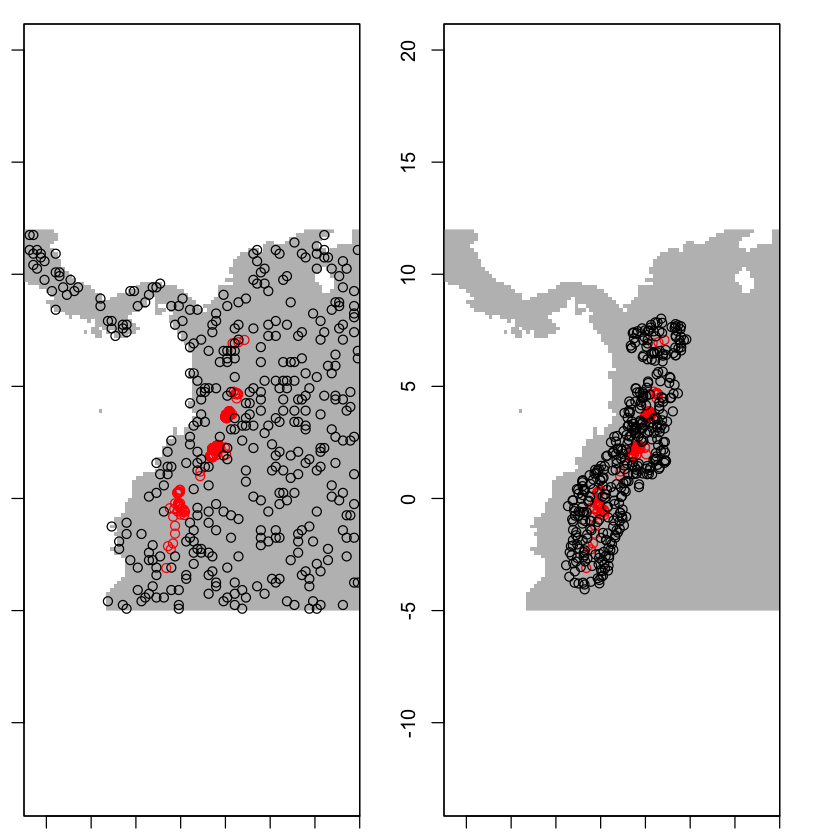

In [11]:
par(mfrow=c(1,2), mar=c(1,1,1,1))
# Random points on land
plot(land, col='grey', legend=FALSE)
plot(st_geometry(tapir_GBIF), add=TRUE, col='red')
plot(pseudo_dismo, add=TRUE)
# Random points within ~ 100 km but not closer than ~ 20 km
plot(land, col='grey', legend=FALSE)
plot(st_geometry(tapir_GBIF), add=TRUE, col='red')
plot(pseudo_nearby, add=TRUE)

A really useful starting point for further detail on pseudo absences is the following study:

> Barbet‐Massin, M., Jiguet, F., Albert, C.H. and Thuiller, W. (2012), Selecting pseudo‐absences for species distribution models: how, where and how many?. Methods in Ecology and Evolution, 3: 327-338. [doi:10.1111/j.2041-210X.2011.00172.x](https://doi:10.1111/j.2041-210X.2011.00172.x)


### Testing and training dataset 

One important part of the modelling process is to keep separate data for *training* the model (the process of fitting the model to data) and for *testing* the model (the process of checking model performance). Here we will use a 20:80 split - retaining 20% of the data for testing.

In [12]:
# Use kfold to add labels to the data, splitting it into 5 parts
tapir_GBIF$kfold <- kfold(tapir_GBIF, k=5)
# Do the same for the pseudo-random points
pseudo_dismo$kfold <- kfold(pseudo_dismo, k=5)
pseudo_nearby$kfold <- kfold(pseudo_nearby, k=5)

One other important concept in test and training is **cross validation**. This is where a model is fitted and tested multiple times, using different subsets of the data, to check that model performance is not dependent on one specific partition of the data. One common approach is *k-fold* cross-validation (hence the function name above). This splits the data into $k$ partitions and then uses each partition in turn as the test data.

If you come to use species distribution models in research, it is worth reading the following paper on an alternative approach to model evaluation that moves away from the standard performance statistics towards a more ecologically informed approach.

> Warren, DL, Matzke, NJ, Iglesias, TL. Evaluating presence‐only species distribution models with discrimination accuracy is uninformative for many applications. J Biogeogr. 2020; 47: 167– 180. [https://doi.org/10.1111/jbi.13705](https://doi.org/10.1111/jbi.13705).


## Species Distribution Modelling

Now we've got all of our data set up we can progress to some actual modelling!

### The BIOCLIM model

One of the earliest species distribution models is BIOCLIM. 

> Nix, H.A., 1986. A biogeographic analysis of Australian elapid snakes. In: Atlas of Elapid Snakes of Australia. (Ed.) R. Longmore, pp. 4-15. Australian Flora and Fauna Series Number 7. Australian Government Publishing Service: Canberra.

It is not a particularly good method, but it is possible to fit the model and predict with **only species presence data** and without using (pseudo-)absence data. The way the model works is to sample environmental layers at species locations. A cell in the wider map then gets a score based on how close to the species' median value for each layer it is. 

This kind of approach is often called a _bioclimatic envelope_, which is where the model name comes from. The BIOCLIM *variables* that we loaded earlier were designed to be used with the BIOCLIM algorithm.

#### Fitting the model

To fit a bioclimatic envelope, we need the environmental layers and a matrix of XY coordinates for the training data showing where the species is observed. The `st_coordinates` function is a useful `sf` function for extracting point coordinates: it does also work with lines and polygons, but the output is much more complex!

In [13]:
# Get the coordinates of 80% of the data for training 
train_locs <- st_coordinates(subset(tapir_GBIF, kfold != 1))
# Fit the model
bioclim_model <- bioclim(bioclim_hist_local, train_locs)

We can now plot the model output to show the envelopes. In the plots below, the argument `p` is used to show the climatic envelop that contains a certain proportion of the data. The `a` and `b` arguments set which layers in the environmental data are compared.

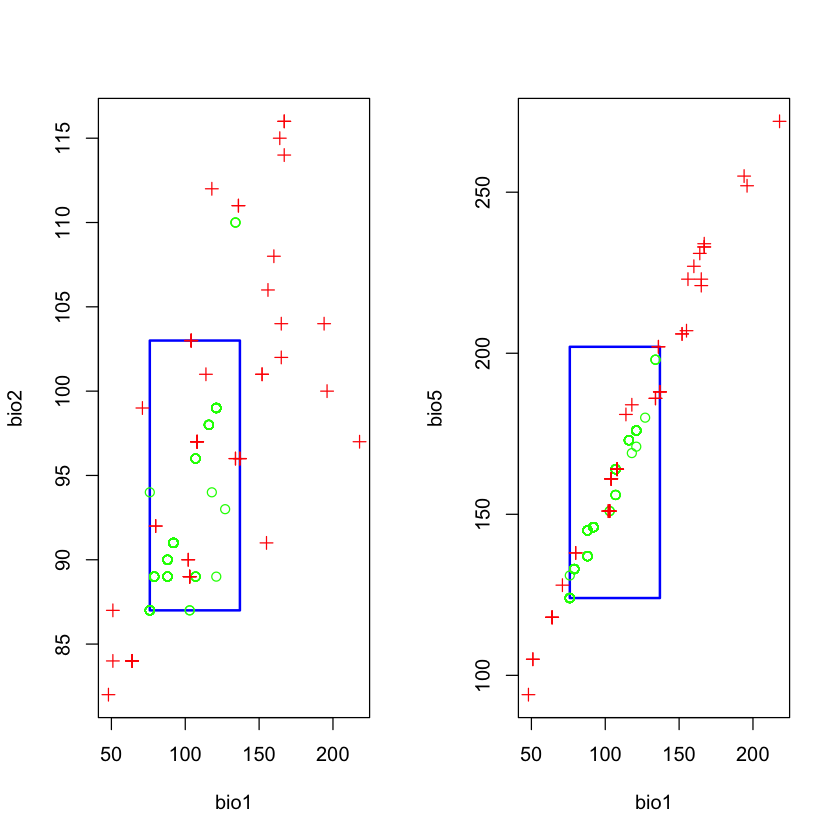

In [14]:
par(mfrow=c(1,2))
plot(bioclim_model, a=1, b=2, p=0.9)
plot(bioclim_model, a=1, b=5, p=0.9)

In that second plot, note that these two variables (mean annual temperature `BIO1` and maximum temperature of the warmest month 'BIO5') are **extremely strongly correlated**. This is not likely to be an issue for this method, but in many models it is a **very bad idea** to have strongly correlated explanatory variables: it is called **[Multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity)** and can cause serious statistical issues. We will revisit this in the GLM example further down.

#### Model predictions

We've now fitted our model and can use the model parameters to predict the `bioclim` score for the whole map. Note that a lot of the map has a **score of zero**: none of the environmental variables in these cells fall within the range seen in the occupied cells.

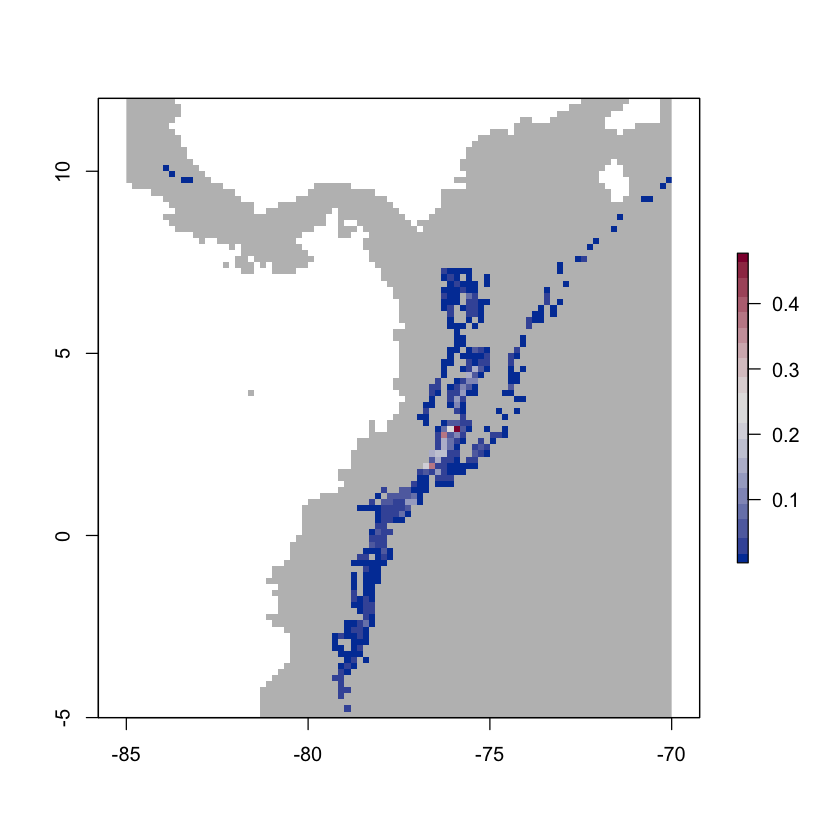

In [15]:
bioclim_pred <- predict(bioclim_hist_local, bioclim_model)
# Create a copy removing zero scores to focus on within envelope locations
bioclim_non_zero <- bioclim_pred
bioclim_non_zero[bioclim_non_zero == 0] <- NA
plot(land, col='grey', legend=FALSE)
plot(bioclim_non_zero, col=hcl.colors(20, palette='Blue-Red'), add=TRUE)

#### Model evaluation

We can also now evaluate our model using the retained test data. Note that here, we do have to **provide absence data**: all of the standard performance metrics come from a confusion matrix, which requires false and true negatives. The output of `evaluate` gives us some key statistics, including AUC.

In [16]:
test_locs <- st_coordinates(subset(tapir_GBIF, kfold == 1))
test_pseudo <- st_coordinates(subset(pseudo_nearby, kfold == 1))
bioclim_eval <- evaluate(p=test_locs, a=test_pseudo, model=bioclim_model, 
                    x=bioclim_hist_local)
print(bioclim_eval)

class          : ModelEvaluation 
n presences    : 77 
n absences     : 77 
AUC            : 0.9685444 
cor            : 0.711078 
max TPR+TNR at : 0.02277582 


We can also create some standard plots. One plot is the ROC curve and the other is a graph of how kappa changes as the threshold used on the model predictions varies. The `threshold` function allows us to find an optimal threshold for a particular measure of performance: here we find the threshold that gives the best kappa.

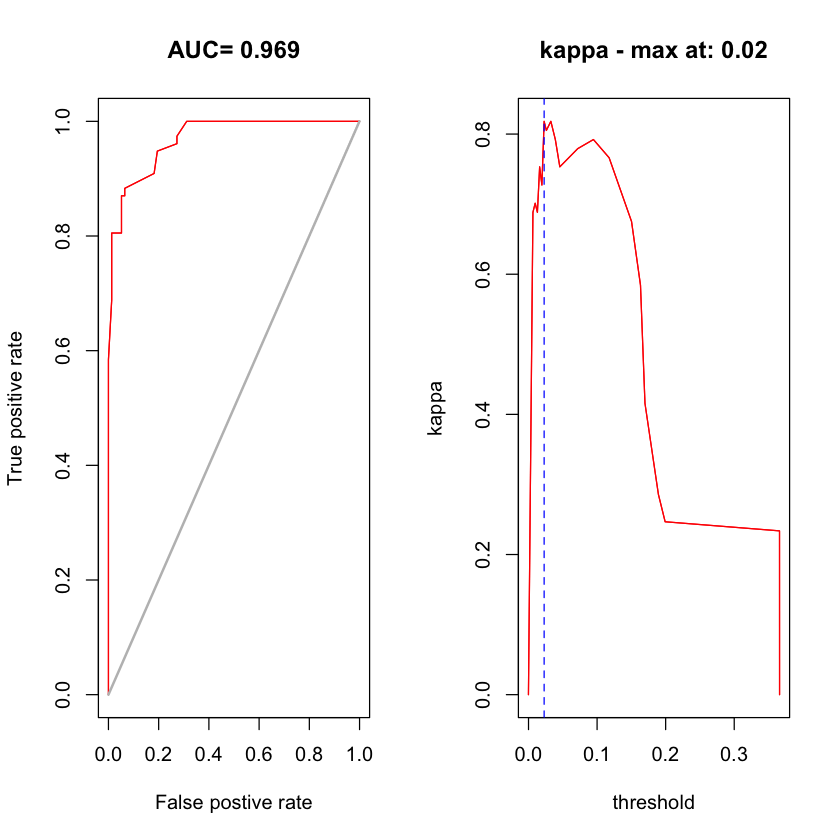

In [17]:
par(mfrow=c(1,2))
# Plot the ROC curve
plot(bioclim_eval, 'ROC', type='l')
# Find the maximum kappa and show how kappa changes with the model threshold
max_kappa <- threshold(bioclim_eval, stat='kappa')
plot(bioclim_eval, 'kappa', type='l')
abline(v=max_kappa, lty=2, col='blue')

#### Species distribution

That gives us all the information we need to make a prediction about the species distribution:

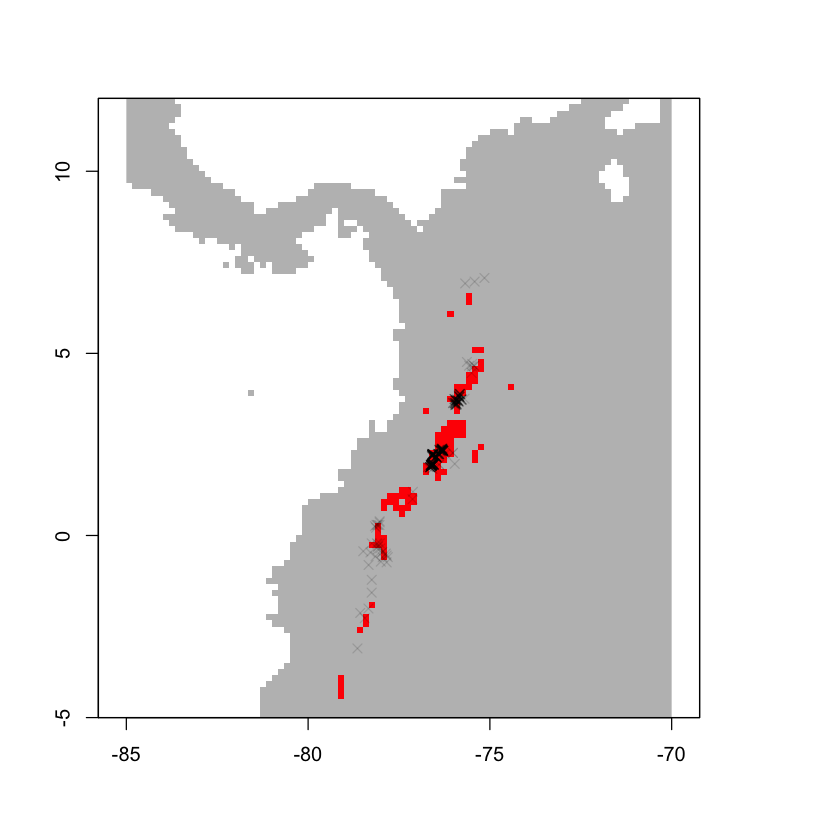

In [18]:
# Apply the threshold to the model predictions
tapir_range <- bioclim_pred >= max_kappa
plot(tapir_range, legend=FALSE, col=c('grey','red'))
plot(st_geometry(tapir_GBIF), add=TRUE, pch=4, col='#00000022')

```{admonition} Future distribution of the tapir

The figure below shows the predicted distribution of the Mountain Tapir in 2050 and the predicted range change - can you figure out how to create these plots?

```

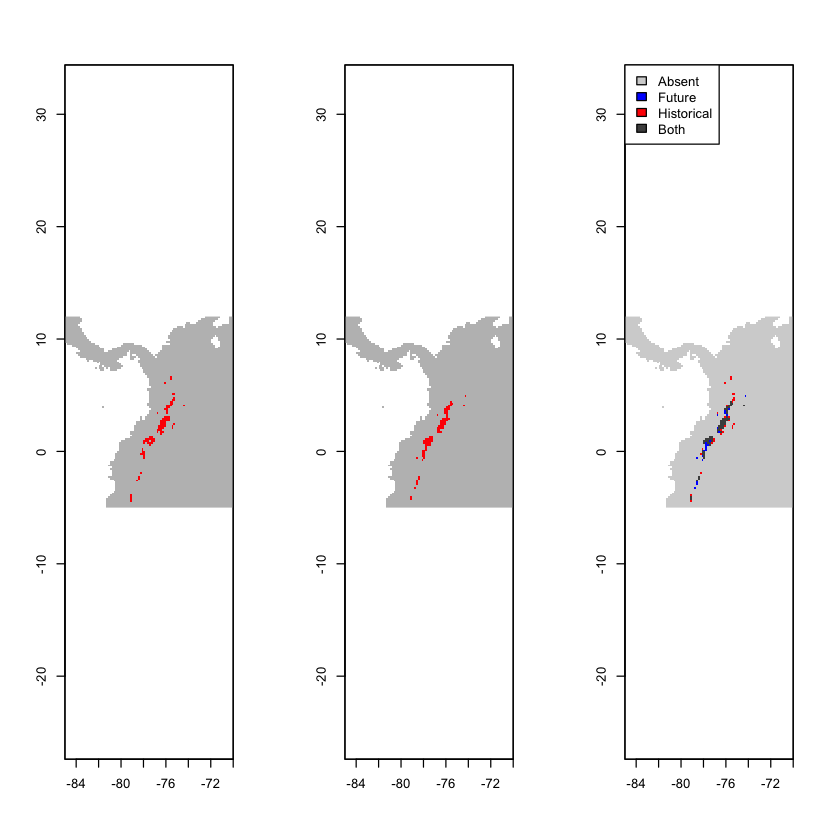

In [19]:
# Predict from the same model but using the future data
bioclim_pred_2050 <- predict(bioclim_2050_local, bioclim_model)
# Apply the same threshold
tapir_range_2050 <- bioclim_pred_2050 >= max_kappa

par(mfrow=c(1,3))
plot(tapir_range, legend=FALSE, col=c('grey','red'))
plot(tapir_range_2050, legend=FALSE, col=c('grey','red'))

# This is a bit of a hack - adding 2 * hist + 2050 gives:
# 0 + 0 - present in neither model
# 0 + 1 - only in future
# 2 + 0 - only in hist
# 2 + 1 - in both
tapir_change <- 2 * (tapir_range) + tapir_range_2050
cols <- c('lightgrey', 'blue', 'red', 'grey30')
plot(tapir_change, col=cols, legend=FALSE)
legend('topleft', fill=cols, legend=c('Absent','Future','Historical', 'Both'), bg='white')

### Generalised Linear Model (GLM)

We are going to jump the gun a bit here and use a GLM. You will cover the statistical background for this later in the course, but essentially it is a kind of regression that allows us to model presence/absence as a **binary response variable** more appropriately. **Do not worry about the statistical details here**: we will treat this as just another algorithm for predicting species presence. You will learn about GLMs later in more theoretical depth - they are hugely useful.

#### Data restructuring


The `bioclim` model allowed us just to provide points and some maps but many other distribution models require us to use a **model formula**, as you saw last week with linear models. So we need to restructure our data into a data frame of species presence/absence and the environmental values observed at the locations of those observations. 

First, we need to combine `tapir_GBIF` and `pseudo_nearby` into a single data frame:

In [20]:
# Create a single sf object holding presence and pseudo-absence data.
# - reduce the GBIF data and pseudo-absence to just kfold and a presence-absence value
present <- subset(tapir_GBIF, select='kfold')
present$pa <- 1
absent <- pseudo_nearby
absent$pa <- 0
# - rename the geometry column of absent to match so we can stack them together.
names(absent) <- c('geometry','kfold','pa')
st_geometry(absent) <- 'geometry'
# - stack the two dataframes
pa_data <- rbind(present, absent)
head(pa_data)

,kfold,pa,geometry
,<int>,<dbl>,<POINT [°]>
1,1,1,POINT (-78.14574 -0.573515)
3,4,1,POINT (-78.08383 -0.316876)
7,5,1,POINT (-78.28517 -0.467604)
8,4,1,POINT (-75.63315 4.763309)
9,1,1,POINT (-75.57059 4.66022)
10,4,1,POINT (-78.02654 -0.215449)


Second, we need to extract the environmental values for each of those points and add it into the data frame.

In [21]:
envt_data <- extract(bioclim_hist_local, pa_data)
pa_data <- cbind(pa_data, envt_data)
head(pa_data)

kfold pa bio1 bio2 bio3 bio4 bio5 bio6 bio7 bio8 geometry                   
1  1     1   61  84   83   550  117   16  101   55  POINT (-78.14574 -0.573515)
3  4     1   64  84   84   475  118   19   99   59  POINT (-78.08383 -0.316876)
7  5     1   51  84   84   457  105    6   99   53  POINT (-78.28517 -0.467604)
8  4     1  155  91   88   298  207  104  103  150  POINT (-75.63315 4.763309) 
9  1     1  157  93   91   322  209  107  102  152  POINT (-75.57059 4.66022)  
10 4     1   64  84   84   475  118   19   99   59  POINT (-78.02654 -0.215449)
   ⋯ bio11 bio12 bio13 bio14 bio15 bio16 bio17 bio18 bio19
1  ⋯  52   1286  130    78   15    387   262   294   358  
3  ⋯  57   1387  146    83   18    434   276   303   394  
7  ⋯  44   1223  132    67   17    367   244   321   255  
8  ⋯ 150   2453  329   115   31    825   415   719   825  
9  ⋯ 152   2227  299    98   34    777   350   659   777  
10 ⋯  57   1387  146    83   18    434   276   303   394  
   geometry                   
1  POINT (-78.14574 -0.573515)
3  POINT (-78.08383 -0.316876)
7  POINT (-78.28517 -0.467604)
8  POINT (-75.63315 4.763309) 
9  POINT (-75.57059 4.66022)  
10 POINT (-78.02654 -0.215449)

#### Fitting the model

We can now fit the GLM using a model formula: the `family=binomial(link = "logit")` is the change that allows us to model binary data better, but we do not need the gory details here. 

Three things you do need to know:

* The number of bioclim variables has been reduced from the full set of 19 down to five. This is because of the issue of multicollinearity - some pairs of `bioclim` variables are very strongly correlated. The five variables are chosen to represent related groups of variables ([show me how!](#Reducing-the-set-of-variables)). 

* The `subset` argument is used to hold back one of the `kfold` partitions for testing.

* The `predict` method for a GLM needs an extra argument (`type='response'`) to make it give us predictions as the probability of species occurence. The default model prediction output (`?predict.glm`) is on the *scale of the linear predictors* - do not worry about what this means now, but note that there are a few places where we need to make this change from the default.

The model fitting code is:

In [22]:
glm_model <- glm(pa ~ bio2 + bio4 + bio3 + bio1 + bio12, data=pa_data, 
                 family=binomial(link = "logit"),
                 subset=kfold != 1)

Using a GLM gives us the significance of different variables - this table is very similar to a linear model summary. It is interpreted in much the same way.

In [23]:
# Look at the variable significances - which are important
summary(glm_model)


Call:
glm(formula = pa ~ bio2 + bio4 + bio3 + bio1 + bio12, family = binomial(link = "logit"), 
    data = pa_data, subset = kfold != 1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9439  -0.1356   0.0347   0.4295   3.0607  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.895e+00  7.770e+00  -1.274   0.2028    
bio2         5.657e-02  2.459e-02   2.300   0.0214 *  
bio4        -7.802e-05  2.003e-03  -0.039   0.9689    
bio3         1.245e-01  7.734e-02   1.610   0.1074    
bio1        -7.509e-02  7.417e-03 -10.124  < 2e-16 ***
bio12        1.862e-03  3.334e-04   5.584 2.35e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 848.41  on 611  degrees of freedom
Residual deviance: 285.94  on 606  degrees of freedom
AIC: 297.94

Number of Fisher Scoring iterations: 7


It can also be helpful to look at **response plots**: these show how the probability of a species being present changes with a given variable. These are predictions for each variable in turn, holding all the other variables at their median value.

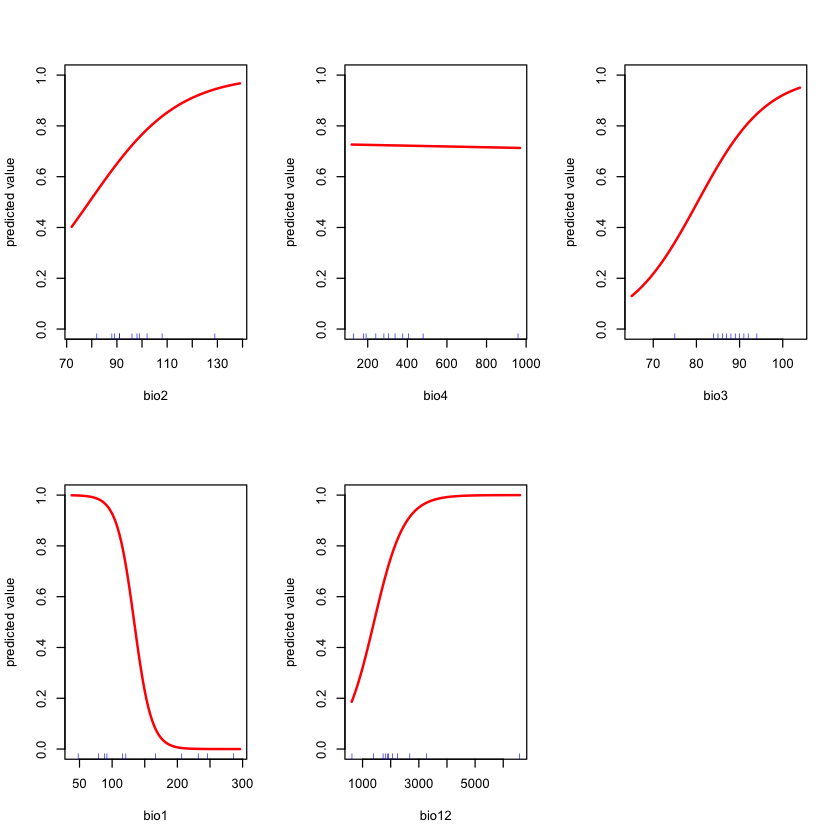

In [24]:
# Response plots
response(glm_model, fun=function(x, y, ...) predict(x, y, type='response', ...))

#### Model predictions and evaluation

We can now evaluate our model using the same techniques as before:

1. Create a prediction layer.

In [25]:
glm_pred <- predict(bioclim_hist_local, glm_model, type='response')

2. Evaluate the model using the test data.

In [26]:
# Extract the test presence and absence
test_present <- st_coordinates(subset(pa_data, pa == 1 & kfold == 1))
test_absent <- st_coordinates(subset(pa_data, pa == 0 & kfold == 1))
glm_eval <- evaluate(p=test_present, a=test_absent, model=glm_model, 
                     x=bioclim_hist_local)
print(glm_eval)

class          : ModelEvaluation 
n presences    : 77 
n absences     : 77 
AUC            : 0.9389442 
cor            : 0.7740639 
max TPR+TNR at : 1.178624 


3. Find the maximum kappa threshold. This is a little more complicated than before the threshold we get is again on the *scale of the linear predictor*. For this kind of GLM, we can use `plogis` to convert back.

In [27]:
max_kappa <- plogis(threshold(glm_eval, stat='kappa'))
print(max_kappa)

[1] 0.7647003


4. Look at some model performance plots

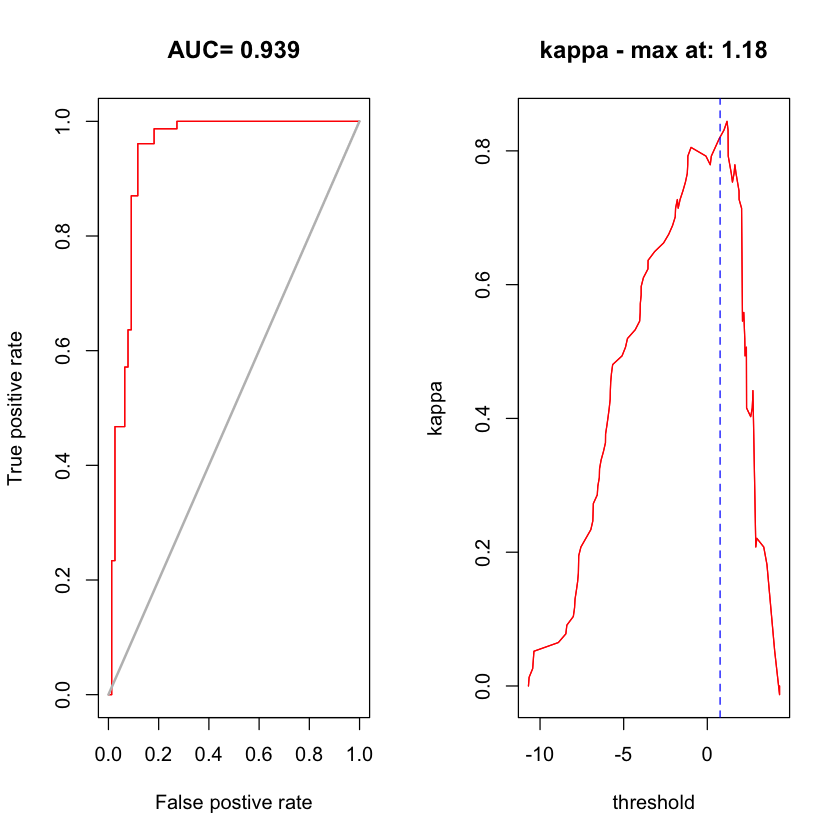

In [28]:
par(mfrow=c(1,2))
# ROC curve and kappa by model threshold
plot(glm_eval, 'ROC', type='l')
plot(glm_eval, 'kappa', type='l')
abline(v=max_kappa, lty=2, col='blue')

#### Species distribution

We can now again use the threshold to convert the model outputs into a predicted species' distribution map and compare current suitability to future suitability.

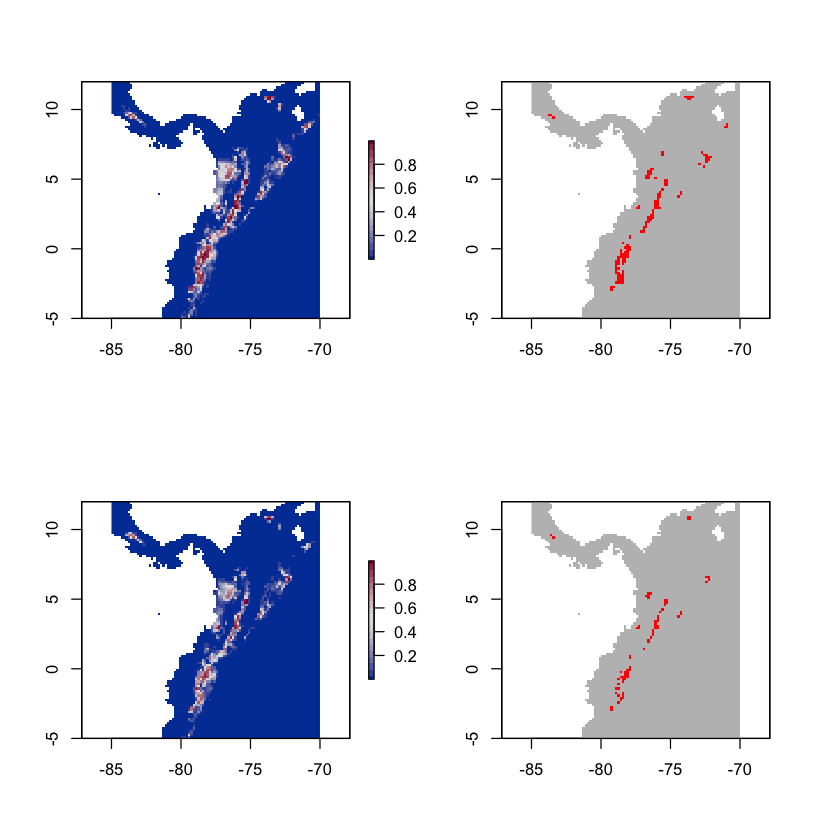

In [29]:
par(mfrow=c(2,2))
# Modelled probability
plot(glm_pred, col=hcl.colors(20, 'Blue-Red'))
# Threshold map
glm_map <- glm_pred >= max_kappa
plot(glm_map, legend=FALSE, col=c('grey','red'))
# Future predictions
glm_pred_2050 <- predict(bioclim_2050_local, glm_model, type='response')
plot(glm_pred_2050, col=hcl.colors(20, 'Blue-Red'))
# Threshold map
glm_map_2050 <- glm_pred_2050 >= max_kappa
plot(glm_map_2050, legend=FALSE, col=c('grey','red'))

One simple way to describe the modelled changes is simply to look at a table of the pair of model predictions:

In [30]:
table(values(glm_map), values(glm_map_2050), dnn=c('hist', '2050'))

       2050
hist    FALSE TRUE
  FALSE  5435    0
  TRUE     62   75

This GLM predicts a 31% loss of existing range for this species by 2050 and almost no expansion into new areas.

## Sandbox - things to try with SDMs

The previous sections have introduced the main approaches for fitting and assessing models so the following sections are intended to give you some things to try. You do not have to try all of them in the practical - pick things that interest you and give them a go.

One of the things to take away from these options are that SDMs have an extremely wide range of options, so testing and comparing many approaches is vital to identifying the features of model predictions that are comparable.

### Modelling a different species

The environmental data is global, so we can use it to model any terrestrial organism for which we can get location data. So:

1. Have a look at the [GBIF species data page](https://www.gbif.org/species/search) and pick a species you would like to model. It probably makes sense to pick something with a relatively limited range.

2. You can the easily get the recorded points using the `dismo` function `gbif`. The example below gets the data for the Mountain Tapir direct from GBIF. It is worth running the command with `download=FALSE` first to get an idea of the number of records you will get - pick a species that has a few thousand at most.

In [31]:
# Check the species without downloading - this shows the number of records
gbif('Tapirus', 'pinchaque', download=FALSE)

[1] 449

In [32]:
# Download the data
locs <- gbif('Tapirus', 'pinchaque')
locs <- subset(locs, ! is.na(lat) | ! is.na(lon))
# Convert to an sf object 
locs <- st_as_sf(locs, coords=c('lon', 'lat'))

449 records found



0-


300-


449 records downloaded



3. You will then need to clean the GBIF points - have a look at the `sdm` vignette mentioned above for ways to tackle cleaning the data. One tip - check the `basisOfRecord` field because the GBIF occurence database includes things like the location of museum specimens. It is _much_ harder to identify species introductions though. 

4. Select an appropriate extent for the modelling and update `model_extent`.

5. Follow the process above to create your model.

### Does our background choice matter?

The examples above have used the spatially structured background data. Does this matter? The plot below compares the GLM fitted with the structured background to the wider sample created using `randomPoints`. Can you create this model?

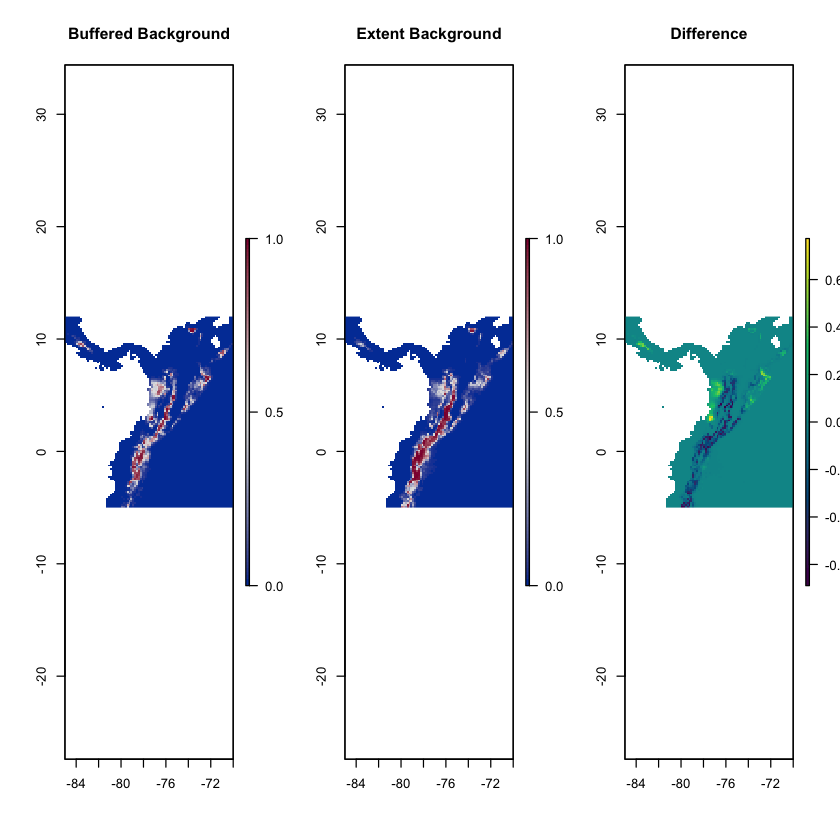

In [33]:
# 1. Create the new dataset
present <- subset(tapir_GBIF, select='kfold')
present$pa <- 1
absent <- pseudo_dismo
absent$pa <- 0
# - rename the geometry column of absent to match so we can stack them together.
names(absent) <- c('geometry','kfold','pa')
st_geometry(absent) <- 'geometry'
# - stack the two dataframes
pa_data_bg2 <- rbind(present, absent)
# - Add the envt.
envt_data <- extract(bioclim_hist_local, pa_data_bg2)
pa_data_bg2 <- cbind(pa_data_bg2, envt_data)

# 2. Fit the model
glm_model_bg2 <-glm(pa ~ bio2 + bio4 + bio3 + bio1 + bio12, data=pa_data_bg2, 
                  family=binomial(link = "logit"),
                  subset=kfold != 1)

# 3. New predictions
glm_pred_bg2 <- predict(bioclim_hist_local, glm_model_bg2, type='response')

# 4. Plot modelled probability using the same colour scheme and using
# axis args to keep a nice simple axis on the legend
par(mfrow=c(1,3))
bks <- seq(0, 1, by=0.01)
cols <- hcl.colors(100, 'Blue-Red')
plot(glm_pred, col=cols, breaks=bks, main='Buffered Background',
     axis.args=list(at=c(0, 0.5, 1)))
plot(glm_pred_bg2, col=cols, breaks=bks, main='Extent Background',
     axis.args=list(at=c(0, 0.5, 1)))
plot(glm_pred - glm_pred_bg2, col= hcl.colors(100), main='Difference')

### Cross validation

```{attention}
This exercise calls for more programming skills - you need to be able to write a loop and set up object to store data for each iteration through the loop.
```

The models above always use the same partitions for testing and training. A better approach is to perform **k-fold cross validation** to check that the model behavour is consistent across different partitions. This allows you to compare the performance of models taking into account the arbitrary structure of the partitioning. 

Here, we have used a completely random partition of the data, but it is worth looking at this recent paper arguing for a spatially structured approach to data partitions in SDM testing:

> Valavi, R, Elith, J, Lahoz‐Monfort, JJ, Guillera‐Arroita, G. blockCV: An r package for generating spatially or environmentally separated folds for k‐fold cross‐validation of species distribution models. Methods Ecol Evol. 2019; 10: 225– 232. [https://doi.org/10.1111/2041-210X.13107](https://doi.org/10.1111/2041-210X.13107)

Try and create the output below, collecting the ROC lines and AUCs across all five possible test partitions of the GLM model. There are two things here that are more difficult:

1.  A way to get the ROC data from the output of `evaluate` - this is not obvious because `dismo` uses a different coding approach ([S4 methods](http://adv-r.had.co.nz/S4.html)) that is a bit more obscure. Don't worry about this - just use the function! Similarly, you need to know that to get the AUC value, you need to use `glm_eval@auc`.

In [34]:
get_roc_data <- function(eval){
    #' get_roc_data
    #' 
    #' This is a function to return a dataframe of true positive
    #' rate and false positive rate from a dismo evalulate output
    #' 
    #' @param eval An object create by `evaluate` (S4 class ModelEvaluation)
    
    roc <- data.frame(FPR = eval@FPR, TPR = eval@TPR)
    return(roc)
}

2. You want each model evaluation to be carried out using the **same threshold breakpoints**, otherwise it is difficult to align the outputs of the different partitions. We can give `evaluate` a set of breakpoints but - for the GLM - the breakpoints are on that mysterious *scale of the linear predictors*. The following approach allows you to set those breakpoints.

In [35]:
# Take a sequence of probability values from 0 to 1
thresholds <- seq(0, 1, by=0.01)
# Convert to the default scale for a binomial GLM
thresholds <- qlogis(thresholds)
# Use in evaluate
eval <- evaluate(p=test_present, a=test_absent, model=glm_model, 
                  x=bioclim_hist_local, tr=thresholds)

[1] 0.9389442 0.9406163 0.9559791 0.9880540 0.9686288


[1] 0.9584445


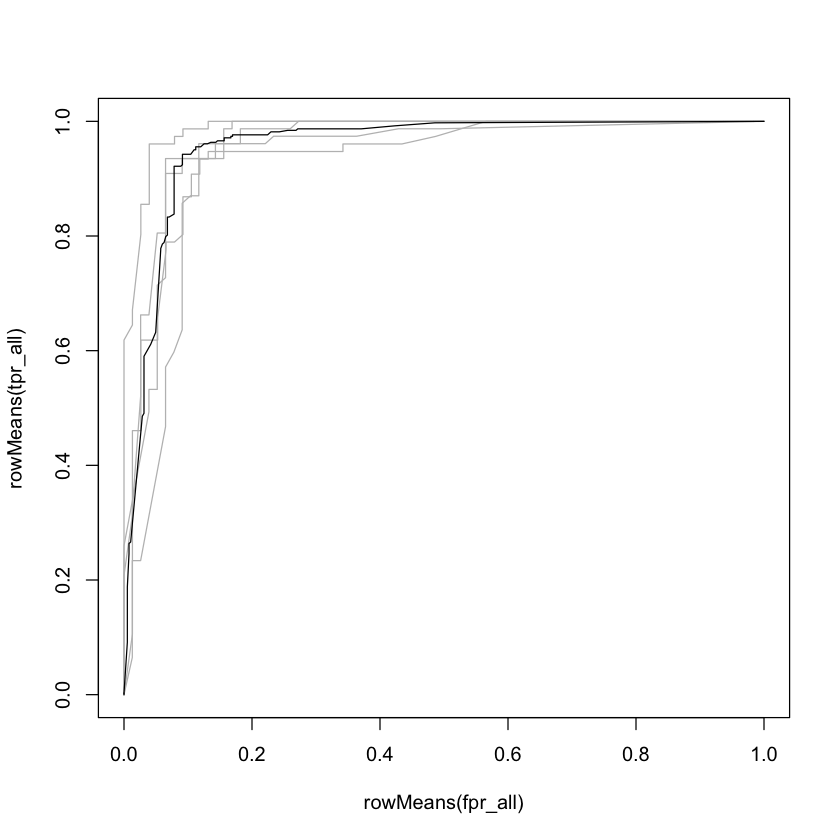

In [36]:
# Make some objects to store the data
tpr_all <- matrix(ncol=5, nrow=length(thresholds))
fpr_all <- matrix(ncol=5, nrow=length(thresholds))
auc <- numeric(length=5)

# Loop over the values 1 to 5
for (test_partition in 1:5) {

    # Fit the model, holding back this test partition
    model <- glm(pa ~ bio2 + bio4 + bio3 + bio1 + bio12, data=pa_data, 
                 family=binomial(link = "logit"),
                 subset=kfold != test_partition)
    
    # Evaluate the model using the retained partition
    test_present <- st_coordinates(subset(pa_data, pa == 1 & kfold == test_partition))
    test_absent <- st_coordinates(subset(pa_data, pa == 0 & kfold == test_partition))
    eval <- evaluate(p=test_present, a=test_absent, model=glm_model, 
                     x=bioclim_hist_local, tr=thresholds)

    # Store the data
    auc[test_partition] <- eval@auc
    roc <- get_roc_data(eval)
    tpr_all[,test_partition] <- roc$TPR
    fpr_all[,test_partition] <- roc$FPR
}

# Create a blank plot to showing the mean ROC and the individual traces
plot(rowMeans(fpr_all), rowMeans(tpr_all), type='n')

# Add the individual lines
for (test_partition in 1:5) {
  lines(fpr_all[, test_partition], tpr_all[, test_partition], col='grey')
}

# Add the mean line
lines(rowMeans(fpr_all), rowMeans(tpr_all))

print(auc)
print(mean(auc))

## Reducing the set of variables

The details of this selection process are hidden below. I'm using clustering to find groups - you do not need to look at this but I do not like hiding my working!

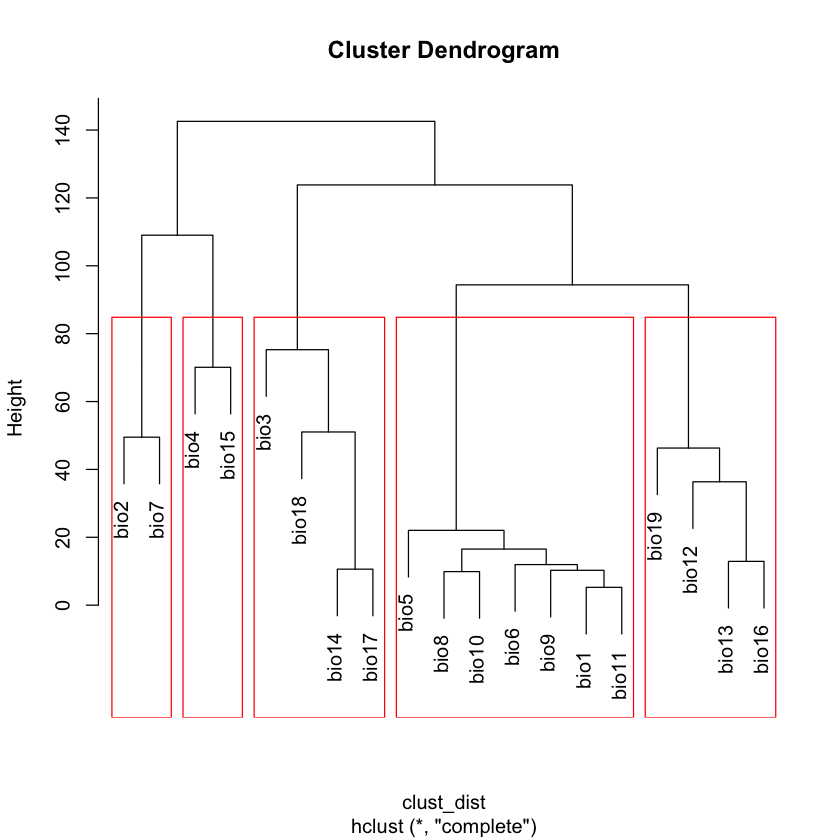

In [37]:
# We can use the values from the environmental data in a cluster algorithm.
# This is a statistical process that groups sets of values by their similarity
# and here we are using the local raster data (to get a good local sample of the 
# data correlation) to perform that clustering.
clust_data <- values(bioclim_hist_local)
clust_data <- na.omit(clust_data)
# Scale and center the data
clust_data <- scale(clust_data)
# Transpose the data matrix to give variables as rows
clust_data <- t(clust_data)
# Find the distance between variables and cluster
clust_dist <- dist(clust_data)
clust_output <- hclust(clust_dist)
plot(clust_output)
# And then pick one from each of five blocks - haphazardly.
rect.hclust(clust_output, k=5)